In [1]:
# there is a change added today

The code failed because of a fatal error:
	Error sending http request and maximum retry encountered..

Some things to try:
a) Make sure Spark has enough available resources for Jupyter to create a Spark context.
b) Contact your Jupyter administrator to make sure the Spark magics library is configured correctly.
c) Restart the kernel.


In [1]:
# """Environment Set Up"""
# ## Need to create a Virtual Environment in Sagemaker using python=3.8.5 and then add that virtual environment as a Custom Kernel.

# """Below Commands can create the virtual environment and then add a Custom Kernel"""
# !conda create --name text_classify python=3.8.5 -y
# !source activate text_classify
# !conda install ipykernel -y

# !python -m ipykernel install --user --name text_classify --display-name "text_classify"

In [ ]:
!pip3 install datasets

In [ ]:
"""Here we are doing installation of Dependencies and importing desired packages."""
#!pip install seaborn
#!python -m pip install setfit
import numpy as np
import pandas as pd
import datasets
from datasets import load_dataset
from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer

In [ ]:
!conda install -c huggingface -c conda-forge datasets

done
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::s3transfer==0.10.1=pyhd8ed1ab_0
  - conda-forge/noarch::s3fs==0.4.2=py_0
  - conda-forge/noarch::nb_conda_kernels==2.3.1=pyh707e725_4
  - conda-forge/noarch::jupyter_console==6.6.3=pyhd8ed1ab_0
  - conda-forge/noarch::nbclient==0.10.0=pyhd8ed1ab_0
  - conda-forge/noarch::qtconsole-base==5.5.2=pyha770c72_0
  - conda-forge/noarch::nbconvert-core==7.2.9=pyhd8ed1ab_0
  - conda-forge/noarch::jupyter_server==2.14.0=pyhd8ed1ab_0
  - conda-forge/noarch::nbconvert-pandoc==7.2.9=pyhd8ed1ab_0
  - conda-forge/noarch::nbconvert==7.2.9=pyhd8ed1ab_0
  - conda-forge/noarch::notebook-shim==0.2.4=pyhd8ed1ab_0
  - conda-forge/noarch::nbclassic==0.5.1=pyhd8ed1ab_0
  - conda-forge/noarch::notebook==6.5.6=pyha770c72_0
  - conda-forge/noarch::jupyter==1.0.0=pyhd8ed1ab_10
  - conda-forge/noarch::nb_conda==2.2.1=unix_7
  - conda-for

In [ ]:
"""Training Data Created in HuggingFace provided dataset structure. Each of the train, test and validation CSVs are 
created seperately using pythonic automation. Below specification is going to create three splits of data stored in the csv 
and features is synonymous to columns."""
dataset1 = load_dataset("csv",  "multilabel" , data_files={
                                            "train": "dataset/train_dataset_5.csv",
                                            "test": "dataset/test_dataset_5.csv", 
                                            "validation": "dataset/validation_dataset_5.csv"
})

In [4]:
"""Glimpse of Traing Data. Test and Validation also has similar structure, typical to SetFit Training 
Data for Multi-Class Classificatio,"""
data_glimpse = pd.read_csv("dataset/train_dataset_5.csv")
data_glimpse.head()

,text,label_payroll_journal,label_payroll_register,label_payroll_register_with_er_taxes,label_payroll_register_with_ytd
0,payroll register with er taxes Lodeke Paffett ...,0,0,1,0
1,payroll register Challace Erie OF ID LLC (5737...,0,1,0,0
2,0940 1404-9863 Alaskan Resorts 0940 1404-9863 ...,1,0,0,0
3,"payroll register with YTD Oxarc, Inc. (1886)",0,0,0,1
4,0940 1404-9863 garden city jeep chrysler dodge...,1,0,0,0


In [5]:
dataset1 

DatasetDict({
    train: Dataset({
        features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd'],
        num_rows: 399
    })
})

In [6]:
features = dataset1["train"].column_names
features.remove("text")
features

['label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd']

In [7]:
"""Randomly Selecting 40 Examples or Few Shots from Each Class Label that will be used to Fine Tune the Base Model of SBERT"""
num_samples = 40
samples = np.concatenate(
                        [np.random.choice(np.where(dataset1["train"][f])[0],num_samples) for f in features]
                        )

In [8]:
 """For each record we are going to update a list with an index indicating that record's class membership. This is to ultimately
 cretae desired format of finetuning data as seen in train_dataset."""
def encode_labels(record):
            return {"labels": [record[feature] for feature in features]}

In [9]:
dataset = dataset1.map(encode_labels)

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd', 'labels'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd', 'labels'],
        num_rows: 400
    })
    validation: Dataset({
        features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd', 'labels'],
        num_rows: 399
    })
})

In [11]:
train_dataset = dataset["train"].select(samples)

In [12]:
train_dataset

Dataset({
    features: ['text', 'label_payroll_journal', 'label_payroll_register', 'label_payroll_register_with_er_taxes', 'label_payroll_register_with_ytd', 'labels'],
    num_rows: 160
})

In [13]:
train_dataset[80]

{'text': 'payroll register with er taxes Gigabox (157748)',
 'label_payroll_journal': 0,
 'label_payroll_register': 0,
 'label_payroll_register_with_er_taxes': 1,
 'label_payroll_register_with_ytd': 0,
 'labels': [0, 0, 1, 0]}

In [14]:
train_dataset[0]

{'text': '0940 1404-9863 Nevermore Chemicals 0940 1404-9863 Nevermore Chemicals payroll journal employee name id hours, earnings, reimbursements and other payments withholdings deductions net pay allocations description rate hours earnings reimb &other payments payroll journal',
 'label_payroll_journal': 1,
 'label_payroll_register': 0,
 'label_payroll_register_with_er_taxes': 0,
 'label_payroll_register_with_ytd': 0,
 'labels': [1, 0, 0, 0]}

In [15]:
"""To be used for generating performance metrics."""
eval_dataset = dataset["validation"]  

In [16]:
"""Initializing a Basemodel to be used for fine-tuning as expected by SetFit framework. """
#model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-mpnet-base-v2", multi_target_strategy="one-vs-rest")
model = SetFitModel.from_pretrained("sentence-transformers/paraphrase-albert-small-v2", multi_target_strategy="one-vs-rest")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [17]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=32,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
    column_mapping={"text": "text", "labels": "label"} # Map dataset columns to text/label expected by trainer
)

In [20]:
import time

In [19]:
---

SyntaxError: invalid syntax (1947214667.py, line 1)

In [21]:
start_time = time.time()
trainer.train()
end_time = time.time()
runtime = end_time - start_time
print(f"The training run-time is : {runtime} .\n")

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 100.02it/s]
***** Running training *****
  Num examples = 6400
  Num epochs = 1
  Total optimization steps = 200
  Total train batch size = 32
Epoch: 100%|██████████| 1/1 [01:00<00:00, 60.22s/it]


The training run-time is : 60.69050979614258 .



In [22]:
metrics = trainer.evaluate()

Applying column mapping to evaluation dataset
***** Running evaluation *****


In [23]:
metrics

{'accuracy': 1.0}

# SAVE MODEL
## (NOTE:Change name incase of retrain)

In [25]:
model_path = './models/model03-20072023_paraphrase-albert-small-v2'
model._save_pretrained(model_path)

# Load the Saved Model from Disk for Prediction

In [26]:
saved_model = SetFitModel._from_pretrained(model_path)

# Prediction On Test Data and Manual Calculation of Confusion Matrix

In [27]:
import pandas as pd
test_dataset = pd.read_csv('dataset/test_dataset_5.csv')
test_dataset

,text,label_payroll_journal,label_payroll_register,label_payroll_register_with_er_taxes,label_payroll_register_with_ytd
0,0940 1404-9863 Ioha Guns and Arms 0940 1404-98...,1,0,0,0
1,payroll register with YTD EF Yakolev Stennes L...,0,0,0,1
2,0940 1404-9863 New York Estates pvt 0940 1404-...,1,0,0,0
3,0940 1404-9863 New York Estates pvt 0940 1404-...,1,0,0,0
4,payroll register Kuhlman Inc (G2959),0,1,0,0
...,...,...,...,...,...
395,payroll register with er taxes NM Gariff Otter...,0,0,1,0
396,payroll register Bryant Ranch Prepack (44018),0,1,0,0
397,payroll register White-Buckridge (50069),0,1,0,0
398,payroll register DD Leander Popham LLC (171958),0,1,0,0


In [28]:
"""In the below code we are creating a list which contains all the predicted class labels for the text column of test_dataset.
This will be used as a proxy for predicted_label in the manual calculation of confusion matrix whihc is done in the code 
that follows. For getting the actual_label for each text column we are going to use 
"""
test_labels = test_dataset['text'].to_list()
#test_labels
preds = saved_model(test_labels)
preds

tensor([[1, 0, 0, 0],
        [0, 0, 0, 1],
        [1, 0, 0, 0],
        ...,
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0]])

In [29]:
pred_lol = [[f for f, p in zip(features, ps) if p] for ps in preds] #list of list 

In [30]:
y_pred = [e for ele in pred_lol for e in ele]

In [31]:
y_pred

['label_payroll_journal',
 'label_payroll_register_with_ytd',
 'label_payroll_journal',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_ytd',
 'label_payroll_journal',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_ytd',
 'label_payroll_register',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd',
 'label_payroll_jo

# Confusion Matrix

In [32]:
#https://stackoverflow.com/questions/50607740/reverse-a-get-dummies-encoding-in-pandas
# Code to get y_test from test_dataset(reverse one-hot encoding)
def cm_prep(df):
    """Converted text column into index """
    temp = df.set_index('text') 
    #print(temp)
    """index is not treated as column"""
    label_cols = temp.columns.to_list()
    """ """
    temp = temp[temp==1].stack().reset_index().drop(0, axis=1)
    print(temp)
    y_test = temp['level_1'].to_list()
    return y_test,label_cols

In [33]:
y_test, label_cols = cm_prep(test_dataset)

                                                  text  \
0    0940 1404-9863 Ioha Guns and Arms 0940 1404-98...   
1    payroll register with YTD EF Yakolev Stennes L...   
2    0940 1404-9863 New York Estates pvt 0940 1404-...   
3    0940 1404-9863 New York Estates pvt 0940 1404-...   
4                payroll register Kuhlman Inc (G2959)    
..                                                 ...   
395  payroll register with er taxes NM Gariff Otter...   
396     payroll register Bryant Ranch Prepack (44018)    
397          payroll register White-Buckridge (50069)    
398   payroll register DD Leander Popham LLC (171958)    
399    payroll register OC Stitt Chinery Inc (369866)    

                                  level_1  
0                   label_payroll_journal  
1         label_payroll_register_with_ytd  
2                   label_payroll_journal  
3                   label_payroll_journal  
4                  label_payroll_register  
..                                    .

In [34]:
y_test

['label_payroll_journal',
 'label_payroll_register_with_ytd',
 'label_payroll_journal',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_ytd',
 'label_payroll_journal',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_ytd',
 'label_payroll_register_with_ytd',
 'label_payroll_register',
 'label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd',
 'label_payroll_jo

In [35]:
label_cols

['label_payroll_journal',
 'label_payroll_register',
 'label_payroll_register_with_er_taxes',
 'label_payroll_register_with_ytd']

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

def confusion_matrix_eval(y_test, y_pred, label_names):
    
    #print(f"csv_df actual and predicted label lists:\n actual is {y_test}\n predicted is {y_pred}\n")
    cm = confusion_matrix(y_test, y_pred,labels= label_names)
    print(f"\n cm from the list:{cm}\n")
    cm_df = pd.DataFrame(cm,
                         index = label_names, 
                         columns = label_names)
    print(cm_df)

    #Plotting the confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()
    
    labels = cm_df.columns.to_list()

    def process_cm(confusion_mat, i=0, to_print=True):
        # i means which class to choose to do one-vs-the-rest calculation
        # rows are actual obs whereas columns are predictions
        TP = confusion_mat[i,i]  # correctly labeled as i
        FP = confusion_mat[:,i].sum() - TP  # incorrectly labeled as i
        FN = confusion_mat[i,:].sum() - TP  # incorrectly labeled as non-i
        TN = confusion_mat.sum().sum() - TP - FP - FN
        if to_print:
            print('TP: {}'.format(TP))
            print('FP: {}'.format(FP))
            print('FN: {}'.format(FN))
            print('TN: {}'.format(TN))
        return TP, FP, FN, TN

    new_df = {}
    for i,label in enumerate(labels):  # each label
        print('Confusion matrix  for {}'.format(label))
        TP, FP, FN, TN = process_cm(cm, i, to_print=True)
        accuracy = (TP+TN)/(TP + FP + FN + TN)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        f1_score = 2 * (precision * recall) / (precision + recall)
        new_df[label] = [TP, FP, FN, TN, accuracy, precision, recall, f1_score]

    temp  = pd.DataFrame(new_df,
                         index = ['TP','FP','FN','TN','accuracy','precision','recall','f1_score'], 
                         columns = label_names)

    confusion_matrix_final = pd.concat([cm_df,temp])
    
    return confusion_matrix_final

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



 cm from the list:[[ 89   0   0   0]
 [  0 116   0   0]
 [  0   0  95   0]
 [  0   0   0 100]]

                                      label_payroll_journal  \
label_payroll_journal                                    89   
label_payroll_register                                    0   
label_payroll_register_with_er_taxes                      0   
label_payroll_register_with_ytd                           0   

                                      label_payroll_register  \
label_payroll_journal                                      0   
label_payroll_register                                   116   
label_payroll_register_with_er_taxes                       0   
label_payroll_register_with_ytd                            0   

                                      label_payroll_register_with_er_taxes  \
label_payroll_journal                                                    0   
label_payroll_register                                                   0   
label_payroll_register_with_er_t

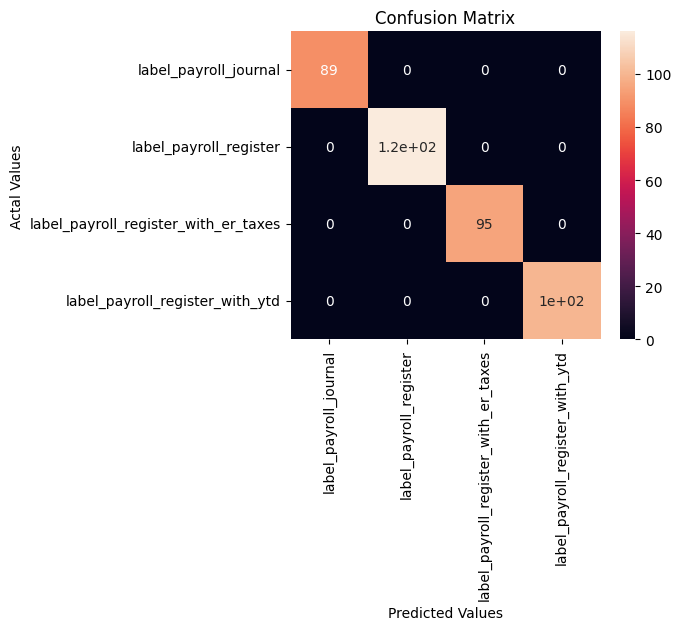

Confusion matrix  for label_payroll_journal
TP: 89
FP: 0
FN: 0
TN: 311
Confusion matrix  for label_payroll_register
TP: 116
FP: 0
FN: 0
TN: 284
Confusion matrix  for label_payroll_register_with_er_taxes
TP: 95
FP: 0
FN: 0
TN: 305
Confusion matrix  for label_payroll_register_with_ytd
TP: 100
FP: 0
FN: 0
TN: 300


,label_payroll_journal,label_payroll_register,label_payroll_register_with_er_taxes,label_payroll_register_with_ytd
label_payroll_journal,89.0,0.0,0.0,0.0
label_payroll_register,0.0,116.0,0.0,0.0
label_payroll_register_with_er_taxes,0.0,0.0,95.0,0.0
label_payroll_register_with_ytd,0.0,0.0,0.0,100.0
TP,89.0,116.0,95.0,100.0
FP,0.0,0.0,0.0,0.0
FN,0.0,0.0,0.0,0.0
TN,311.0,284.0,305.0,300.0
accuracy,1.0,1.0,1.0,1.0
precision,1.0,1.0,1.0,1.0


In [37]:
confusion_matrix_eval(y_test, y_pred, label_cols)